# Calculating evaluation metrics with Python

In this week's lectures you have seen how to evaluate a model based on quality metrics.

Let's see how we can calculate those metrics on a model with Python. To illustrate, let's train a logistic regression on the Iris dataset, like you did in the Regression instruction.

First off, import the dataset and separate descriptive attributes from target.

In [1]:
import pandas as pd

iris = pd.read_csv(r"iris.csv")
X = iris.iloc[:,0:4]
y = iris.iloc[:,-1]

Then, let's separate training and test data. We can do it with a `scikit-learn` function, `train_test_split`. This function will split _randomly_ the data in a training and test set, in a 75%-25% proportion; the stratify parameter makes sure the classes are **balanced**.

In [2]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(112, 4)
(38, 4)
(112,)
(38,)


Now, let's fit a logistic regression model to the training data...

In [3]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', multi_class='auto')
classifier.fit(train_X, train_y.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

...and predict the target value for the test data.

In [4]:
pred_y = classifier.predict(test_X)

At this point, we can calculate a confusion matrix for the real and predicted values of the test data target. It is very straightforward.

Notice that, since the split is random, it is not guaranteed that the confusion matrix will contain exactly the same values for each execution of this Jupyter Notebook.

In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, pred_y)
print(cm)

[[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]


...alright, maybe it IS straightforward, but it is not good looking.

A better alternative is the `crosstab` function from Pandas:

In [6]:
import numpy as np
pred_y = np.array(pred_y)
true_y = np.array(test_y)

pd.crosstab(np.array(true_y), np.array(pred_y), rownames=['True'], colnames=['Predicted'], margins=True)


Predicted        Iris-setosa  Iris-versicolor  Iris-virginica  All
True                                                              
Iris-setosa               12                0               0   12
Iris-versicolor            0               12               1   13
Iris-virginica             0                1              12   13
All                       12               13              13   38

We can calculate the common metrics of our classification as follows.

Notice that **precision**, **recall** and **f-measure** need an additional parameter. The default behaviour works only for **binary** classification; for multiclass, we have to specify the aggregation function to be used as average.

Passing `None` we obtain the **class-wise** metrics. You can find the other options in the docs: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print(precision_score(true_y, pred_y, average=None))
print(recall_score(true_y, pred_y, average=None))
print(accuracy_score(true_y, pred_y))
print(f1_score(true_y, pred_y, average=None))

[1.         0.92307692 0.92307692]
[1.         0.92307692 0.92307692]
0.9473684210526315
[1.         0.92307692 0.92307692]


## Binary classification case

In the case of binary classification, we can of course use the `sklearn.metrics.confusion_matrix` to get true/false positive/negative, flattening the matrix.
Let's do it again on the Iris dataset, but removing the instances with label _Iris-setosa_ to turn it into a binary classification problem.

In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

iris = pd.read_csv(r"iris.csv")
iris = iris.loc[iris['Species'] != 'Iris-setosa']
X = iris.iloc[:,0:4]
y = iris.iloc[:,-1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y)

classifier = LogisticRegression(solver='lbfgs')
classifier.fit(train_X, train_y.ravel())

pred_y = classifier.predict(test_X)

import numpy as np
pred_y = np.array(pred_y)
true_y = np.array(test_y)

cm = confusion_matrix(true_y, pred_y)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

10 2 0 13


And we can calculate the common metrics as follows. In this case, we don't need to specify the aggregation function since the classification is binary (binary metrics is the default behaviour). Since the labels are strings we must, however, specify which label is the _positive_ and which is the _negative_.

In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print(precision_score(true_y, pred_y, pos_label='Iris-versicolor'))
print(recall_score(true_y, pred_y, pos_label='Iris-versicolor'))
print(accuracy_score(true_y, pred_y))
print(f1_score(true_y, pred_y, pos_label='Iris-versicolor'))

1.0
0.8333333333333334
0.92
0.9090909090909091


### ROC and AUC

When a binary classifier returns a probability estimate or a degree of belief for a certain class we can plot the ROC curve that you have seen in the lecture, and then compute the AUC. Refer to the slides for the theory behind it; the only difference is that the Python implementation of the AUC score calculates the area with the trapezoidal rule, rather than rectangles; the resulting AUC score is more precise, but the formula is more complex.

Note that the `auc` function we use is a generic function that can calculate the area under any curve, having the x and y points.
There is also the way to directly calculate the AUC from labels and probabilities, with the `sklearn.metrics.roc_auc_score` function.

<IPython.core.display.Javascript object>


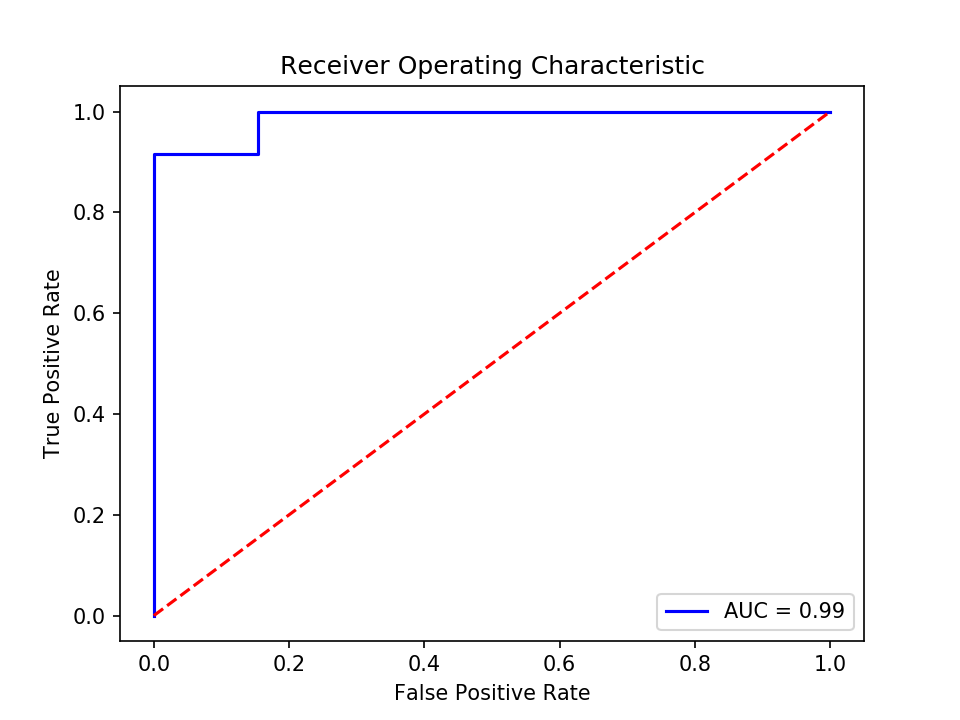

In [10]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_y, classifier.predict_proba(test_X)[:,0], drop_intermediate=False, pos_label='Iris-versicolor')
roc_auc = auc(fpr, tpr)

%matplotlib notebook
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Rectangle rule: 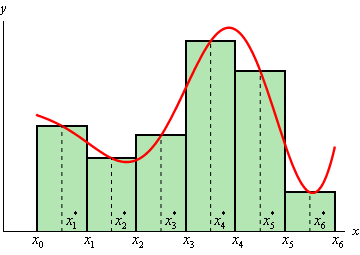

Trapezoidal rule: 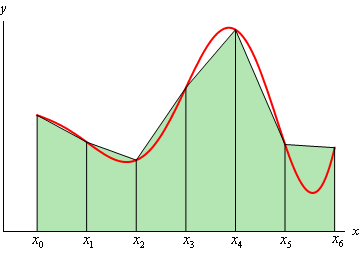

## Cross validation

Cross-validating a model with K-fold cross validation can be done through the `cross_val_score` of Sklearn. This method takes care of everything, you just have to specify the classifier, the training data, the labels, the metric to be evaluated, and the number of folds.

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

iris = pd.read_csv(r"iris.csv")
X = iris.iloc[:,0:4]
y = iris.iloc[:,-1]

classifier = LogisticRegression(solver='lbfgs', multi_class='auto')

cross_val_score(classifier, X, y, scoring='accuracy', cv=5)

C:\Users\pegoraro\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\pegoraro\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\pegoraro\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])

It is also possible to use the functionalities of Scikit-learn to manually generate indices for the folds.

In [12]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
folds = KFold(n_splits=4)
for train_index, test_index in folds.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3 4 5 6 7] TEST: [0 1]
TRAIN: [0 1 4 5 6 7] TEST: [2 3]
TRAIN: [0 1 2 3 6 7] TEST: [4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7]
